In [1]:
import sys
sys.path.append('/usr/lib/freecad/lib')

import FreeCAD as App
import Part
from FreeCAD import Base
import pyvista as pv
import tempfile
import os
pv.set_jupyter_backend('static')
pv.start_xvfb()

In [2]:
# 새로운 문서 생성
doc = App.newDocument()

# 원기둥 생성
radius = 10.0
height = 30.0
center = Base.Vector(0, 0, 0)
direction = Base.Vector(0, 0, 1)
cylinder = Part.makeCylinder(radius, height, center, direction)

# STEP 파일로 저장 (영구적으로)
step_file = "cylinder.step"
cylinder.exportStep(step_file)
print(f"STEP 파일이 저장되었습니다: {step_file}")

# STL 파일로 임시 저장 (PyVista 시각화용)
temp_stl = os.path.join(tempfile.gettempdir(), "temp_cylinder.stl")
cylinder.exportStl(temp_stl)

STEP 파일이 저장되었습니다: cylinder.step


In [3]:
# 형상 정보 출력
print(f"\n원기둥 정보:")
print(f"- 반지름: {radius}mm")
print(f"- 높이: {height}mm")
print(f"- 부피: {cylinder.Volume:.2f}mm³")
print(f"- 표면적: {cylinder.Area:.2f}mm²")


원기둥 정보:
- 반지름: 10.0mm
- 높이: 30.0mm
- 부피: 9424.78mm³
- 표면적: 2513.27mm²


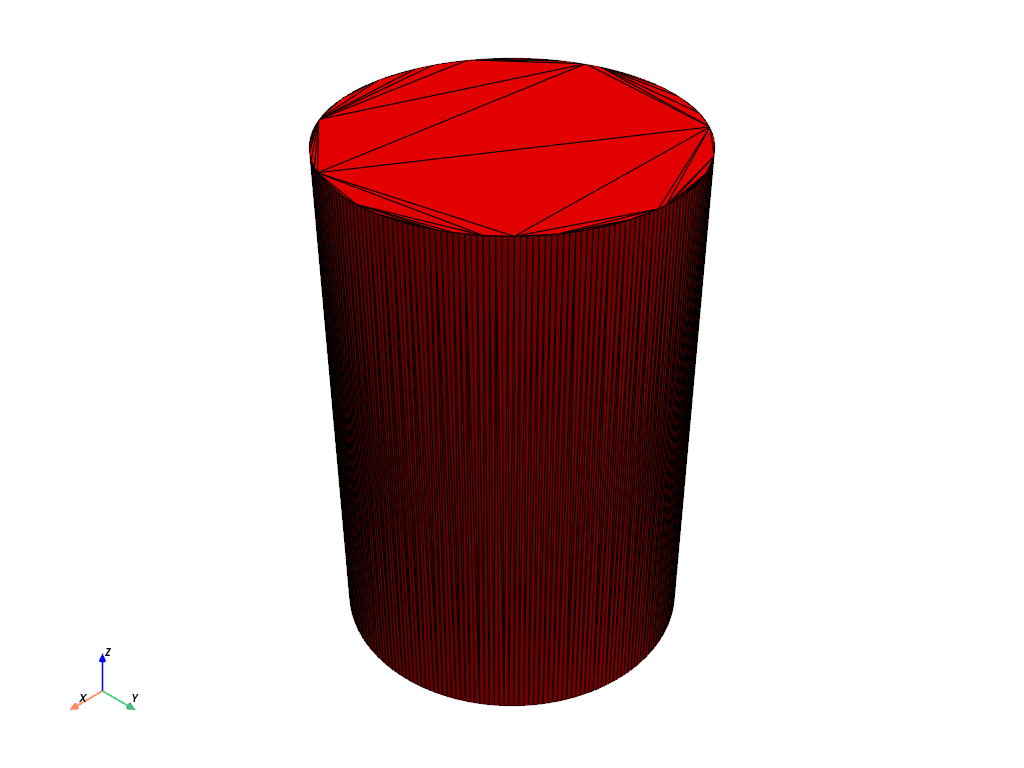

In [4]:
# PyVista로 시각화
mesh = pv.read(temp_stl)

# Jupyter에서 시각화하기 위한 플로터 설정
plotter = pv.Plotter()
plotter.add_mesh(mesh, color='red', show_edges=True)
plotter.add_axes()  # 좌표축 추가
plotter.camera_position = 'iso'  # 등각 뷰

# 시각화
plotter.show()

# 임시 STL 파일 삭제
os.remove(temp_stl)

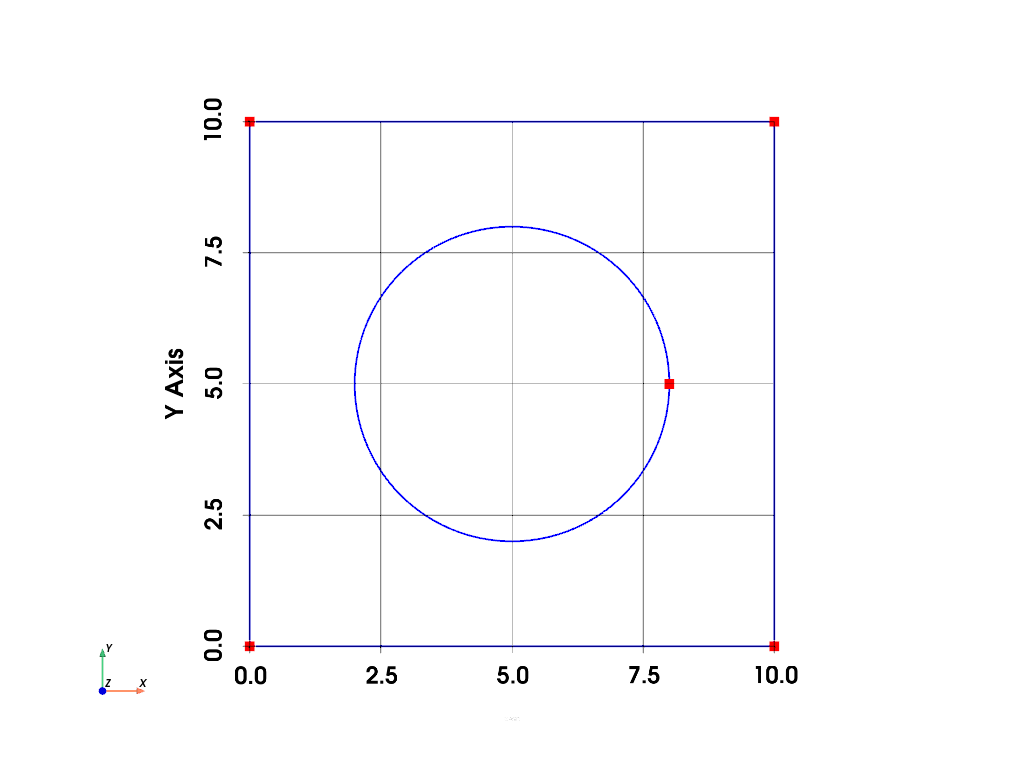


형상 정보:
엣지 개수: 5
정점 개수: 5


In [5]:
import FreeCAD as App
import Part
import Sketcher
from FreeCAD import Base
import pyvista as pv
import numpy as np

def convert_freecad_points_to_numpy(points):
    """FreeCAD 점들을 numpy 배열로 변환"""
    return np.array([[p.x, p.y, p.z] for p in points])

def visualize_faces(faces, plotter):
    """면(face)을 시각화"""
    for face in faces:
        # 면의 삼각화
        mesh = face.tessellate(0.1)  # 0.1은 메시 정밀도
        vertices = np.array(mesh[0])
        faces = np.array(mesh[1])
        
        # 면 데이터를 PyVista 메시로 변환
        surf = pv.PolyData(vertices, faces)
        plotter.add_mesh(surf, color='green', opacity=0.5)

def visualize_edges(edges, plotter):
    """선(edge)을 시각화"""
    for edge in edges:
        # 엣지에서 점들을 추출
        points = edge.discretize(100)  # 곡선의 경우 더 많은 점으로 표현
        points_np = convert_freecad_points_to_numpy(points)
        
        # PyVista 라인 생성
        line = pv.lines_from_points(points_np)
        plotter.add_mesh(line, color='blue', line_width=2)

def visualize_vertices(vertices, plotter):
    """정점을 시각화"""
    for vertex in vertices:
        point = np.array([[vertex.X, vertex.Y, vertex.Z]])
        point_cloud = pv.PolyData(point)
        plotter.add_mesh(point_cloud, color='red', point_size=10)



# 새 문서 생성
doc = App.newDocument()

# 스케치 생성
sketch = doc.addObject('Sketcher::SketchObject', 'Sketch')
sketch.addGeometry(Part.LineSegment(Base.Vector(0,0,0), Base.Vector(10,0,0)), False)
sketch.addGeometry(Part.LineSegment(Base.Vector(10,0,0), Base.Vector(10,10,0)), False)
sketch.addGeometry(Part.LineSegment(Base.Vector(10,10,0), Base.Vector(0,10,0)), False)
sketch.addGeometry(Part.LineSegment(Base.Vector(0,10,0), Base.Vector(0,0,0)), False)

# 원도 추가
sketch.addGeometry(Part.Circle(Base.Vector(5,5,0), Base.Vector(0,0,1), 3), False)

# 문서 업데이트
doc.recompute()

# Shape 객체 얻기
shape = sketch.Shape

# PyVista 플로터 설정
plotter = pv.Plotter(notebook=True)

# 엣지와 버텍스 시각화
visualize_faces(shape.Faces, plotter)
visualize_edges(shape.Edges, plotter)
visualize_vertices(shape.Vertexes, plotter)

# 좌표축 추가 및 카메라 설정
plotter.add_axes()
plotter.camera_position = 'xy'  # 평면도 뷰
plotter.show_grid()

# 보여주기
plotter.show()

# 형상 정보 출력
print("\n형상 정보:")
print(f"엣지 개수: {len(shape.Edges)}")
print(f"정점 개수: {len(shape.Vertexes)}")

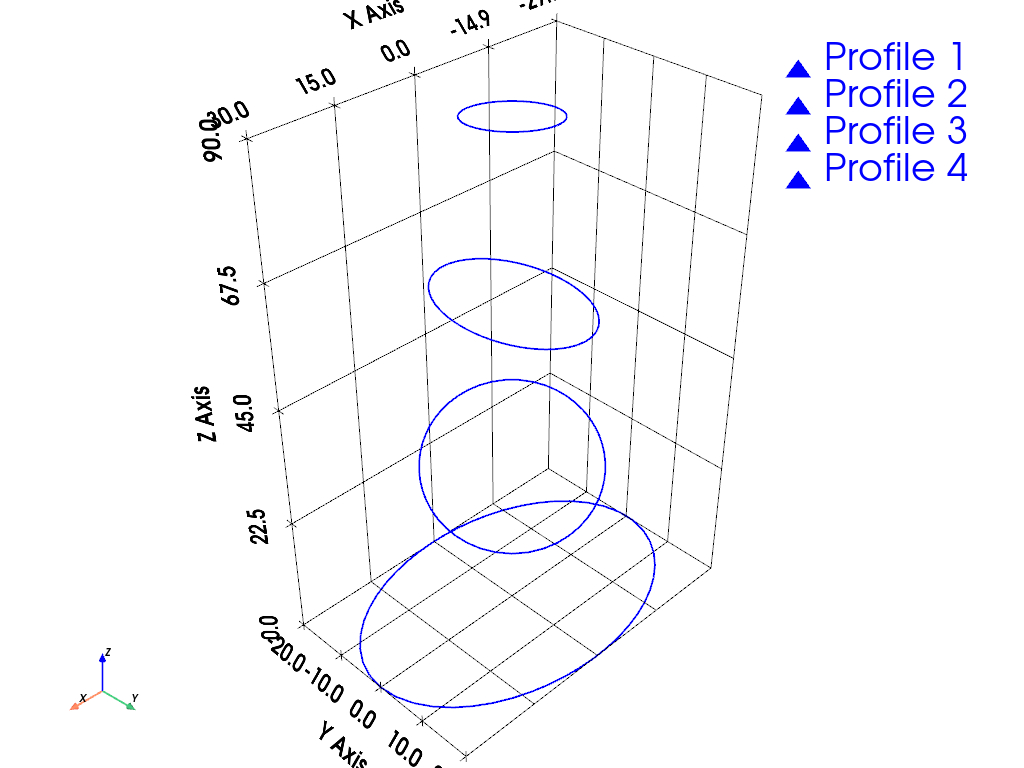

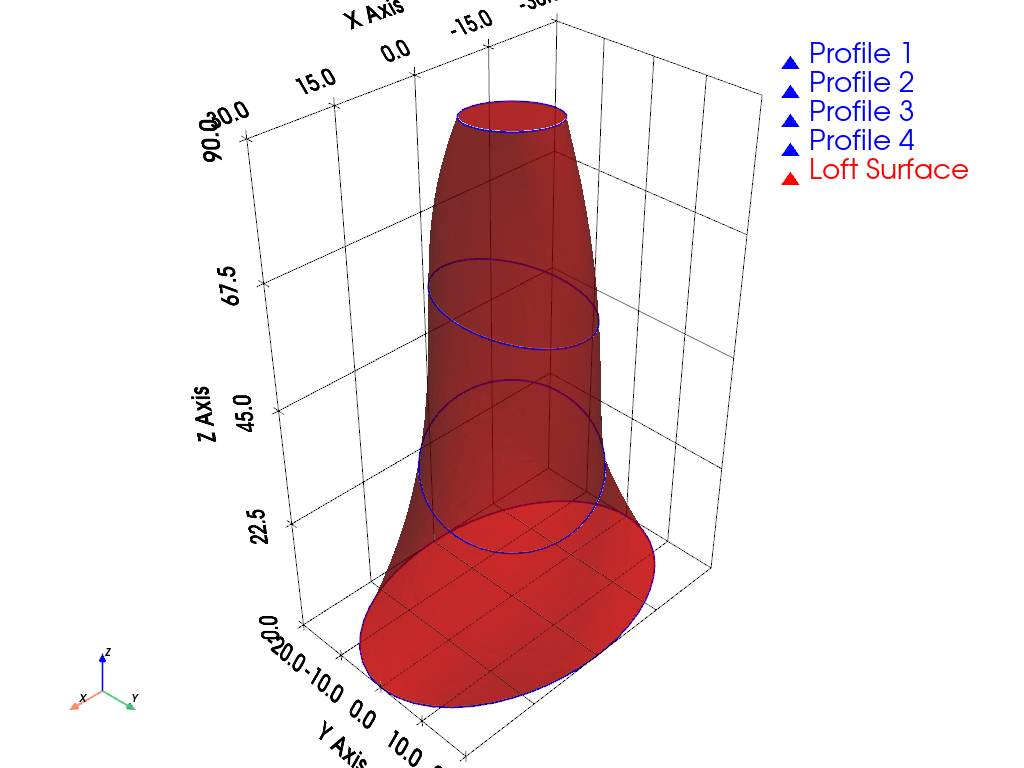


Loft 형상 정보:
부피: 74448.40 mm³
표면적: 11197.43 mm²
프로파일 개수: 4
면(Faces) 개수: 6


In [6]:
import FreeCAD as App
import Part
from FreeCAD import Base
import pyvista as pv
import numpy as np

def create_profile(center, radius, rotation=0):
    """지정된 중심점에서 회전된 타원 프로파일 생성"""
    major_axis = radius * 1.5
    minor_axis = radius
    
    center_point = Base.Vector(center[0], center[1], center[2])
    
    # 타원 생성
    ellipse = Part.Ellipse(
        center_point,
        major_axis,
        minor_axis
    )
    
    edge = ellipse.toShape()
    wire = Part.Wire(edge)
    
    if rotation != 0:
        wire.rotate(center_point, Base.Vector(0,0,1), rotation)
    
    return wire

def convert_shape_to_pyvista(shape):
    """FreeCAD shape를 PyVista 메시로 변환"""
    mesh = shape.tessellate(0.1)
    vertices = np.array(mesh[0])
    
    # faces 배열 재구성
    raw_faces = mesh[1]
    faces = []
    for face in raw_faces:
        faces.extend([len(face)] + list(face))
    faces = np.array(faces)
    
    # PyVista 메시 생성
    return pv.PolyData(vertices, faces=faces)

def visualize_wire(wire, plotter, color='blue', label='Wire'):
    """와이어 형상 시각화"""
    points = []
    for edge in wire.Edges:
        points.extend(edge.discretize(50))
    
    if points:
        points_np = np.array([[p.x, p.y, p.z] for p in points])
        line = pv.lines_from_points(points_np)
        plotter.add_mesh(line, color=color, line_width=2, label=label)

def visualize_construction(profiles, loft_shape=None):
    """생성 과정과 최종 형상을 시각화"""
    plotter = pv.Plotter(notebook=True)
    
    # 프로파일 시각화
    for i, profile in enumerate(profiles):
        visualize_wire(profile, plotter, 
                      color='blue', 
                      label=f'Profile {i+1}')
    
    # Loft 형상 시각화
    if loft_shape:
        try:
            loft_mesh = convert_shape_to_pyvista(loft_shape)
            plotter.add_mesh(loft_mesh, color='red', opacity=0.6, 
                           label='Loft Surface')
        except Exception as e:
            print(f"Loft 메시 변환 중 오류 발생: {e}")
    
    plotter.add_axes()
    plotter.add_legend()
    plotter.camera_position = 'iso'
    plotter.show_grid()
    
    return plotter

# 새 문서 생성
doc = App.newDocument()

# 프로파일 생성
profiles = [
    create_profile([0, 0, 0], 20, 0),
    create_profile([0, 0, 30], 15, 45),
    create_profile([0, 0, 60], 10, 90),
    create_profile([0, 0, 90], 5, 135)
]

# Loft 생성
loft = Part.makeLoft(profiles, True, False, False)
doc.addObject("Part::Feature", "Loft").Shape = loft

# 프로파일만 표시
plotter_profiles = visualize_construction(profiles)
plotter_profiles.show()

# 프로파일과 loft 함께 표시
plotter_complete = visualize_construction(profiles, loft)
plotter_complete.show()

# 형상 정보 출력
print("\nLoft 형상 정보:")
print(f"부피: {loft.Volume:.2f} mm³")
print(f"표면적: {loft.Area:.2f} mm²")
print(f"프로파일 개수: {len(profiles)}")
print(f"면(Faces) 개수: {len(loft.Faces)}")

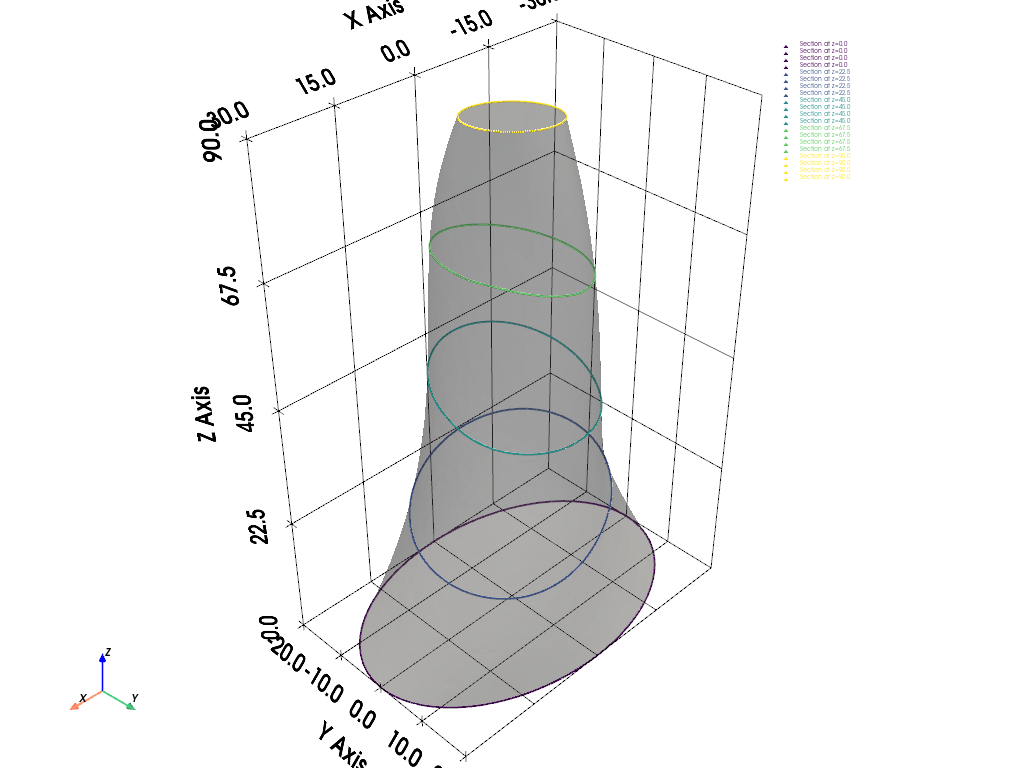


단면 분석 정보:
높이 0.0mm에서의 단면적: 1884.96 mm²
높이 22.5mm에서의 단면적: 1250.07 mm²
높이 45.0mm에서의 단면적: 733.34 mm²
높이 67.5mm에서의 단면적: 361.82 mm²
높이 90.0mm에서의 단면적: 117.81 mm²


In [8]:
def analyze_cross_sections(loft_shape, num_sections=5):
    """특정 높이에서의 단면을 분석하고 시각화"""
    plotter = pv.Plotter(notebook=True)
    
    # 높이별 단면 생성
    z_min = loft_shape.BoundBox.ZMin
    z_max = loft_shape.BoundBox.ZMax
    z_step = (z_max - z_min) / (num_sections - 1)
    
    for i in range(num_sections):
        z = z_min + i * z_step
        
        # 평면 생성 및 단면 구하기
        plane = Part.makePlane(
            200,  # 충분히 큰 평면 크기
            200,
            Base.Vector(-100, -100, z),  # 평면의 좌하단 모서리
            Base.Vector(0, 0, 1)  # 평면의 법선 벡터
        )
        section = loft_shape.common(plane)  # intersection 대신 common 사용
        
        if section.Edges:
            # 단면을 시각화
            for edge in section.Edges:
                points = edge.discretize(50)
                points_np = np.array([[p.x, p.y, p.z] for p in points])
                line = pv.lines_from_points(points_np)
                # 높이에 따라 색상 그라데이션 생성
                color = plt.cm.viridis(i / (num_sections - 1))
                plotter.add_mesh(line, color=color, 
                               line_width=2, 
                               label=f'Section at z={z:.1f}')
    
    # Loft 형상도 함께 표시
    loft_mesh = convert_shape_to_pyvista(loft_shape)
    plotter.add_mesh(loft_mesh, color='gray', opacity=0.3)
    
    plotter.add_axes()
    plotter.add_legend()
    plotter.camera_position = 'iso'
    plotter.show_grid()
    
    return plotter

# matplotlib import 추가
import matplotlib.pyplot as plt

# 단면 분석 시각화
plotter_sections = analyze_cross_sections(loft)
plotter_sections.show()

# 단면적 분석 정보 출력
print("\n단면 분석 정보:")
z_min = loft.BoundBox.ZMin
z_max = loft.BoundBox.ZMax
z_step = (z_max - z_min) / 4
for i in range(5):
    z = z_min + i * z_step
    plane = Part.makePlane(200, 200, Base.Vector(-100, -100, z), Base.Vector(0, 0, 1))
    section = loft.common(plane)
    if section.Edges:
        print(f"높이 {z:.1f}mm에서의 단면적: {section.Area:.2f} mm²")

In [9]:
# STEP 파일로 저장 (영구적으로)
step_file = "loft_sample.step"
loft.exportStep(step_file)
print(f"STEP 파일이 저장되었습니다: {step_file}")

STEP 파일이 저장되었습니다: loft_sample.step
